# Preprocessing - Instacart basket analysis

## Contents

* 4.1 Introduction
* 4.2 Imports
* 4.3 Load Data
* 4.4 Convert data into proper format
    * 4.4.1 Combine orders and users
    * 4.4.2 Purchase quantity of all products
    * 4.4.3 Identify products that are ordered the most
    * 4.4.4 Orders where the customer ordered a product in the top 1000
    * 4.4.5 Creating a user - product interaction matrix
* 4.5 Models
    * 4.5.1 Model 1: Recommend the top 8 products to everyone
    * 4.5.2 Model 2: Recommend random 8 products to everyone
    * 4.5.3 Model 3: Recommend products that similar users bought
    * 4.5.4 Model 4: Recommend the top 8 products that the customer bought
* 4.6 Summary
    

## 4.1 Introduction

In this section, the data is converted into proper format for making recommendations. This will entail having the user IDs as rows and product IDs as columns. The number of times that a customer ordered each product is the value. This will help in identifying users who are similar and help in choosing what products to recommend to each customer.

## 4.2 Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

## 4.3 Load Data

In [2]:
#Importing the aisle, department and product datasets
aisles=pd.read_csv('../raw_data/aisles.csv')
departments=pd.read_csv("../raw_data/departments.csv")
products=pd.read_csv("../raw_data/products.csv")

In [3]:
#Importing the orders and order details
orders=pd.read_csv("../raw_data/orders.csv")
order_details_prior=pd.read_csv("../raw_data/order_products__prior.csv")
order_details_test=pd.read_csv("../raw_data/order_products__train.csv")

## 4.4 Convert data into proper format

### 4.4.1 Combine orders and users

The orders training dataframe does not have the customer ids on them. So, the two dataframes are merged to get the user id's along with the order and product  id's.

In [4]:
#Merge the dataframes to get the user ids for each order
prior_orders_merged=order_details_prior.merge(orders.loc[:,["user_id","order_id"]],on='order_id')
prior_orders_merged.drop(["add_to_cart_order"],axis=1,inplace=True)
prior_orders_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column      Dtype
---  ------      -----
 0   order_id    int64
 1   product_id  int64
 2   reordered   int64
 3   user_id     int64
dtypes: int64(4)
memory usage: 1.2 GB


In [5]:
#Merge test dataframe to alse get user ids along with the orders
test_orders_merged=order_details_test.merge(orders.loc[:,["user_id","order_id"]],on='order_id')
test_orders_merged.drop(["add_to_cart_order"],axis=1,inplace=True)
test_orders_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype
---  ------      --------------    -----
 0   order_id    1384617 non-null  int64
 1   product_id  1384617 non-null  int64
 2   reordered   1384617 non-null  int64
 3   user_id     1384617 non-null  int64
dtypes: int64(4)
memory usage: 52.8 MB


### 4.4.2 Purchase quantity of all products

In [6]:
#Get the count of purchases for all products
most_purchased_prior=prior_orders_merged["product_id"].value_counts()

 <font color='Blue' size =5> For the baseline recommendation system, let us find the top 1000 products that were bought the most. We can recommend these 1000 items to users that bought similar items

### 4.4.3 Identify products that are ordered the most

In [7]:
#Get the 1000 most frequently purchased products
top_1000=most_purchased_prior[:1000]
top_1000=pd.DataFrame(top_1000)
top_1000.reset_index(inplace=True)
top_1000.columns=["product_id","purchased_qty"]
top_1000=top_1000.merge(products,on="product_id",validate="1:1")
print(top_1000.head())
print(top_1000.tail())

   product_id  purchased_qty            product_name  aisle_id  department_id
0       24852         472565                  Banana        24              4
1       13176         379450  Bag of Organic Bananas        24              4
2       21137         264683    Organic Strawberries        24              4
3       21903         241921    Organic Baby Spinach       123              4
4       47209         213584    Organic Hass Avocado        24              4
     product_id  purchased_qty                 product_name  aisle_id  \
995       18023           5474        Organic Coconut Water       115   
996       20378           5468                Chicken Broth        69   
997       43014           5453  Sliced Baby Bella Mushrooms       123   
998        3339           5448    Organic Russet Potato Bag       123   
999       27020           5445                Mandarins Bag        24   

     department_id  
995              7  
996             15  
997              4  
998      

<font color='Blue' size =5> On average, the user has about 8 items per order. So, let us recommend 8 items for each user

### 4.4.4 Orders where the customer ordered a product in the top 1000

In [8]:
#Keep only the most purchased items in their orders to train and make predictions
top1000_prior_orders=prior_orders_merged.loc[prior_orders_merged["product_id"].isin(top_1000["product_id"])]
top1000_test_orders=test_orders_merged.loc[test_orders_merged["product_id"].isin(top_1000["product_id"])]

#Remove unwanted columns of data for finding user-product interactions
top1000_prior_orders=top1000_prior_orders.drop(["reordered","order_id"],axis=1)
print(top1000_prior_orders.info())
top1000_test_orders=top1000_test_orders.drop(["reordered","order_id"],axis=1)
print(top1000_test_orders.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17515025 entries, 0 to 32434487
Data columns (total 2 columns):
 #   Column      Dtype
---  ------      -----
 0   product_id  int64
 1   user_id     int64
dtypes: int64(2)
memory usage: 400.9 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 721946 entries, 2 to 1384616
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   product_id  721946 non-null  int64
 1   user_id     721946 non-null  int64
dtypes: int64(2)
memory usage: 16.5 MB
None


<font color='Blue' size =5> The top 1000 items make more than 50% of all items in our prior orders. So, it will be a good set for making recommendations. Now, to make the user-product interaction matrix to identify how many times a user has bought a product and find similar users.

### 4.4.5 Creating a user - product interaction matrix

In [9]:
#Make user-product interaction matrices
user_product_interaction_top1000=top1000_prior_orders.pivot_table(index='user_id', columns='product_id', aggfunc=len, fill_value=np.int8(0),dropna=False)
test_user_product_interaction_top1000=top1000_test_orders.pivot_table(index='user_id', columns='product_id', aggfunc=len, fill_value=np.int8(0),dropna=False)

In [10]:
print(user_product_interaction_top1000)
print(user_product_interaction_top1000.info())

product_id  34     45     196    248    260    311    329    365    432    \
user_id                                                                     
1               0      0     10      0      0      0      0      0      0   
2               0      0      0      0      0      0      0      0      0   
3               0      0      0      1      0      0      0      0      0   
4               0      0      0      0      0      0      0      0      0   
5               0      0      0      0      0      0      0      0      0   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
206205          0      0      0      0      0      0      0      0      0   
206206          0      0      0      0      0      0      0      0      0   
206207          0      0      0      0      0      0      0      0      0   
206208          0      0      0      0      0      2      0      7      0   
206209          0      0      0      0      0      0      0      0      0   

In [11]:
print(test_user_product_interaction_top1000)
print(test_user_product_interaction_top1000.info())
#print(test_user_product_interaction_top1000.max(),test_user_product_interaction_top1000.min()) # To confirm the maximum value and min value

product_id  34     45     196    248    260    311    329    365    432    \
user_id                                                                     
1               0      0      1      0      0      0      0      0      0   
2               0      0      0      0      0      0      0      0      0   
5               0      0      0      0      0      0      0      0      0   
7               0      0      0      0      0      0      0      0      0   
8               0      0      0      0      0      0      0      0      0   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
206199          0      0      0      0      0      0      0      0      0   
206200          0      0      0      0      0      0      0      0      0   
206203          0      0      0      0      0      0      0      0      0   
206205          0      0      0      0      0      0      0      0      0   
206209          0      0      0      0      0      0      0      0      0   

In [12]:
#validate the data is accurate
print(user_product_interaction_top1000.iloc[:,0].sum())

print(top_1000.loc[top_1000["product_id"]==34])

6536
     product_id  purchased_qty          product_name  aisle_id  department_id
817          34           6536  Peanut Butter Cereal       121             14


In [13]:
#get the number of purchases for each customer
m=top1000_test_orders.groupby(["user_id"]).size()
m

user_id
1          6
2         12
5          5
7          2
8         10
          ..
206199     2
206200    12
206203     5
206205    13
206209     2
Length: 119486, dtype: int64

In [14]:
"""
#get the users as dictionary keys and products and values to easily check if a customer bought an item
user_test_dict={}
for user in top1000_test_orders["user_id"]:
    temp=list(top1000_test_orders.loc[top1000_test_orders["user_id"]==user]["product_id"])
    user_test_dict[user]=temp
#user_test_dict
"""

'\n#get the users as dictionary keys and products and values to easily check if a customer bought an item\nuser_test_dict={}\nfor user in top1000_test_orders["user_id"]:\n    temp=list(top1000_test_orders.loc[top1000_test_orders["user_id"]==user]["product_id"])\n    user_test_dict[user]=temp\n#user_test_dict\n'

In [15]:
"""
#Dump user - productdictionary using pickle
import pickle
dictionary_data = {"a": 1, "b": 2}

a_file = open("../data/user_test_dict.pkl", "wb")
pickle.dump(user_test_dict, a_file)
a_file.close()
"""

'\n#Dump user - productdictionary using pickle\nimport pickle\ndictionary_data = {"a": 1, "b": 2}\n\na_file = open("../data/user_test_dict.pkl", "wb")\npickle.dump(user_test_dict, a_file)\na_file.close()\n'

In [16]:
#Load pickled user-product-dictionary
import pickle
a_file = open("../data/user_test_dict.pkl", "rb")
user_test_dict = pickle.load(a_file)
a_file.close()

## 4.5 Models

## 4.5.1 Model 1: Recommend the top 8 products to everyone

For the intial model, the top 8 products will be recommended for all users. So, it does not consider user's purchase history.

In [17]:
#Function to return a random 8 items from top 1000 to recommend to customer
def top_8():
    return list(top_1000["product_id"][:8])

## We will use the Mean Average Precision @ N to evaluate the performance of the recommendation

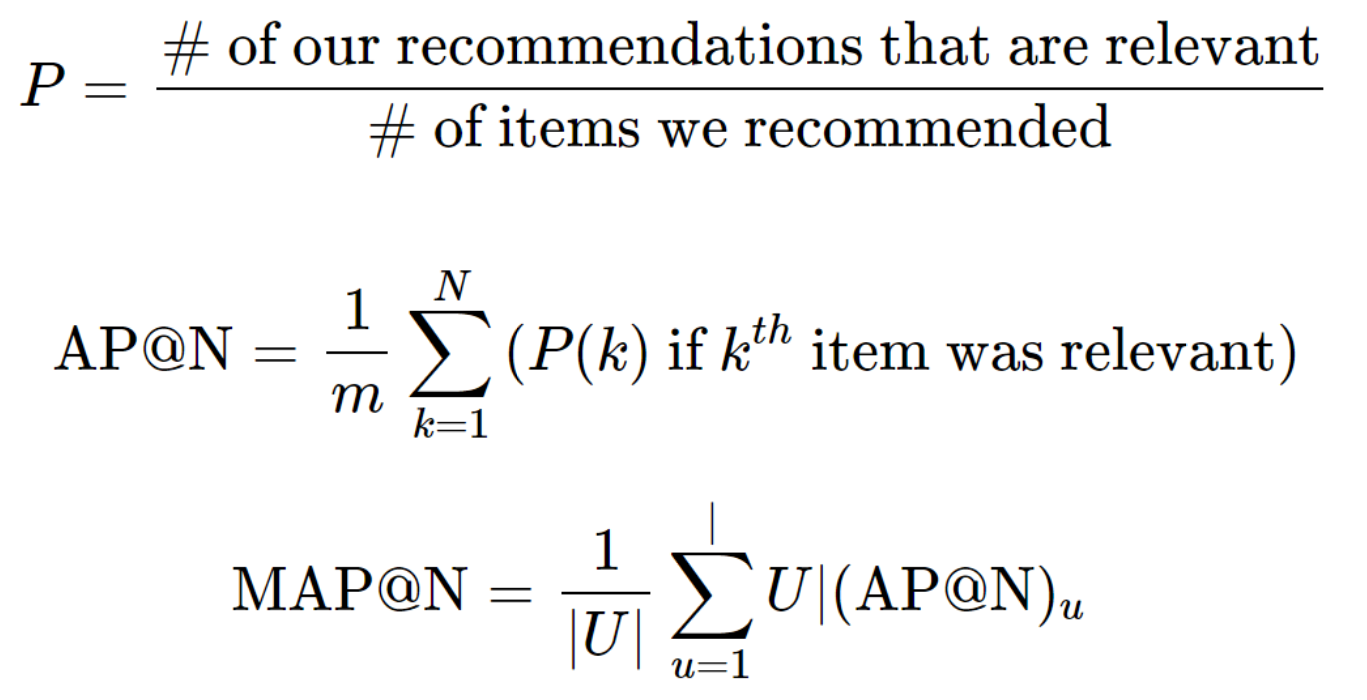

where m is number of items purchased by user, N is number of recommendations and P(k) is precision at k. 

In [18]:
def avg_prec_calc_top_8(user):
    #Get the list of recommendations
    temp=top_8()
    purchased_quantity=m[user] #Get the purchased quantity of user
    user_purchased=user_test_dict[user] #get products purchased by user
    recVspurcahsed=list(pd.Series(temp).isin(user_purchased)) #get a list of true/false for each item for precision
    precisions=[] #list to store the precision at each k
    for indx, rec in enumerate(recVspurcahsed): #calculate precision at k
        precisions.append(sum(recVspurcahsed[:indx+1])/(indx+1))
    avg_prec=(sum(precisions)/len(precisions))/purchased_quantity #calculate average_precision of user
    return round(avg_prec,4)

In [19]:
def mean_avg_prec_calc_top_8(users_to_test): # To calculate mean avg precision among users
    U=len(users_to_test)
    avg_prec_all=[]
    for user in users_to_test:
        avg_prec_all.append(avg_prec_calc_top_8(user))
    mean_avg_prec=sum(avg_prec_all)/U
    return mean_avg_prec

In [20]:
#Calculate performance for model 1:
test_set=m.index
top_8_score=mean_avg_prec_calc_top_8(test_set)
top_8_score

0.020256915454529997

### The MAP score when recommending top 8 products to all customers is <font color='red'>0.0202

## 4.5.2 Model 2: Recommend random 8 products to everyone

In [21]:
#Function to return a random 8 items from top 1000 to recommend to customer
def random_8():
    return list(top_1000["product_id"].sample(n=8))

<font color='Blue' size =5> Calculate the performance of recommending 8 random products to all customers:

In [22]:
def avg_prec_calc(user):
    #Get the list of recommendations
    temp=random_8()
    purchased_quantity=m[user] #Get the purchased quantity of user
    user_purchased=user_test_dict[user] #get products purchased by user
    recVspurcahsed=list(pd.Series(temp).isin(user_purchased)) #get a list of true/false for each item for precision
    precisions=[] #list to store the precision at each k
    for indx, rec in enumerate(recVspurcahsed): #calculate precision at k
        precisions.append(sum(recVspurcahsed[:indx+1])/(indx+1))
    avg_prec=(sum(precisions)/len(precisions))/purchased_quantity #calculate average_precision of user
    return round(avg_prec,4)   

In [23]:
def mean_avg_prec_calc(users_to_test): # To calculate mean avg precision among users
    U=len(users_to_test)
    avg_prec_all=[]
    for user in users_to_test:
        avg_prec_all.append(avg_prec_calc(user))
    mean_avg_prec=sum(avg_prec_all)/U
    return mean_avg_prec

In [24]:
test_set=m.index
random_8_score=mean_avg_prec_calc(test_set)

In [25]:
random_8_score

0.001015820263461836

### The MAP score when recommending 8 random products to all customers is<font color='red'> 0.0010

## 4.5.3 Model 3: Recommend products that similar users bought

<font color='Blue' size =5> The user-product matrix is not in the same scale for all users as users quantity of orders is different. In order to compare the similarity of users, it would be ideal to bring the values to the same scale. So, the quantity of product purchased by a user is divided by the number of orders to get them to be in a scale of 0 to 1. 
    
A value of 0 for this ratio means the user never bought this item and a value of 1 means the user buys this item in every order. 

In [26]:
#List of all users in user-product interaction matrix
users_in_matrix=user_product_interaction_top1000.index
#users_in_matrix.tolist()
users_in_matrix=users_in_matrix.tolist()
print(len(users_in_matrix))

204741


In [27]:
orders_train=orders.loc[orders["eval_set"]=="prior"]
orders_per_user=orders_train.groupby(["user_id"])["order_number"].max()

In [28]:
orders_per_user=orders_per_user.loc[orders_per_user.index.isin(users_in_matrix)]
orders_per_user

user_id
1         10
2         14
3         12
4          5
5          4
          ..
206205     3
206206    67
206207    16
206208    49
206209    13
Name: order_number, Length: 204741, dtype: int64

In [29]:
user_product_int_scaled=user_product_interaction_top1000.div(orders_per_user,axis=0)

In [30]:
#Get the name of products
products_in_matrix=products.loc[products["product_id"].isin(user_product_int_scaled.columns.tolist())]["product_name"]
user_product_int_scaled.columns=products_in_matrix
user_product_int_scaled

product_name,Peanut Butter Cereal,European Cucumber,Soda,Dried Sweetened Cranberries,Cantaloupe,Naturals Savory Turkey Breakfast Sausage,Organic Whole Grassmilk Milk,Cheerios Cereal,Vanilla Almond Breeze Almond Milk,Garnet Sweet Potato (Yam),...,Kids Sensible Foods Broccoli Littles,Organic Half & Half,Coconut Yoghurt,Organic Bunch Beets,Frozen Organic Strawberries,Orange Sparkling Water,Cane Sugar,Classic Hummus Family Size,100% Lactose Free Fat Free Milk,Cucumber Kirby
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.200000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.083333,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.083333
4,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
206206,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.029851,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
206207,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


<font size=5 color="Blue"> Reduce the number of users to find users that are most similar and then use that to recommend prodducts that this customer has never bought

In [31]:
#https://www.kaggle.com/philippsp/book-recommender-collaborative-filtering-shiny

In [32]:
#To find simlar users, let us take 10,000 users and identify their similarity based on purchase of popular products
#The similarity can be calculated on the entire dataframe on a computer with higher performance
sample_users=user_product_int_scaled[:10000]
sample_users

product_name,Peanut Butter Cereal,European Cucumber,Soda,Dried Sweetened Cranberries,Cantaloupe,Naturals Savory Turkey Breakfast Sausage,Organic Whole Grassmilk Milk,Cheerios Cereal,Vanilla Almond Breeze Almond Milk,Garnet Sweet Potato (Yam),...,Kids Sensible Foods Broccoli Littles,Organic Half & Half,Coconut Yoghurt,Organic Bunch Beets,Frozen Organic Strawberries,Orange Sparkling Water,Cane Sugar,Classic Hummus Family Size,100% Lactose Free Fat Free Milk,Cucumber Kirby
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.000,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333
4,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10059,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
10060,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
10061,0.0,0.125,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [33]:
sim_users_matrix=cosine_similarity(sample_users)
similar_users_df=pd.DataFrame(sim_users_matrix,index=user_product_int_scaled.index[:len(sim_users_matrix)],columns=user_product_int_scaled.index[:len(sim_users_matrix)])

In [34]:
similar_users_df

user_id,1,2,3,4,5,6,7,8,9,10,...,10054,10055,10056,10057,10058,10059,10060,10061,10062,10063
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.011542,0.000000,0.000000,0.000000,0.000000,0.010287,0.000000,0.000000,0.000000,...,0.045583,0.000000,0.01134,0.000000,0.000000,0.041667,0.013250,0.000000,0.000000,0.058173
2,0.011542,1.000000,0.100657,0.048970,0.012973,0.000000,0.044882,0.000000,0.159384,0.082016,...,0.045458,0.034311,0.00000,0.350009,0.030971,0.069254,0.011011,0.007556,0.205157,0.188007
3,0.000000,0.100657,1.000000,0.000000,0.000000,0.217732,0.025302,0.128778,0.000000,0.078085,...,0.065233,0.110782,0.00000,0.023063,0.016667,0.000000,0.086908,0.219578,0.208867,0.018066
4,0.000000,0.048970,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.113228,0.123404
5,0.000000,0.012973,0.000000,0.000000,1.000000,0.000000,0.046246,0.000000,0.137952,0.068257,...,0.000000,0.020623,0.00000,0.019320,0.000000,0.000000,0.009928,0.102190,0.014997,0.001816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10059,0.041667,0.069254,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.053000,0.000000,0.000000,0.000000
10060,0.013250,0.011011,0.086908,0.000000,0.009928,0.038706,0.042526,0.045785,0.039032,0.024141,...,0.038654,0.070021,0.00000,0.010933,0.023702,0.053000,1.000000,0.069393,0.033947,0.062691
10061,0.000000,0.007556,0.219578,0.000000,0.102190,0.239046,0.168359,0.131958,0.000000,0.129214,...,0.079576,0.084087,0.00000,0.022507,0.048795,0.000000,0.069393,1.000000,0.087357,0.063472


In [35]:
#To remove the value of 1 for all the items along the diagonal
np.fill_diagonal(similar_users_df.values, np.nan)
similar_users_df

user_id,1,2,3,4,5,6,7,8,9,10,...,10054,10055,10056,10057,10058,10059,10060,10061,10062,10063
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,0.011542,0.000000,0.000000,0.000000,0.000000,0.010287,0.000000,0.000000,0.000000,...,0.045583,0.000000,0.01134,0.000000,0.000000,0.041667,0.013250,0.000000,0.000000,0.058173
2,0.011542,NaN,0.100657,0.048970,0.012973,0.000000,0.044882,0.000000,0.159384,0.082016,...,0.045458,0.034311,0.00000,0.350009,0.030971,0.069254,0.011011,0.007556,0.205157,0.188007
3,0.000000,0.100657,NaN,0.000000,0.000000,0.217732,0.025302,0.128778,0.000000,0.078085,...,0.065233,0.110782,0.00000,0.023063,0.016667,0.000000,0.086908,0.219578,0.208867,0.018066
4,0.000000,0.048970,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.113228,0.123404
5,0.000000,0.012973,0.000000,0.000000,NaN,0.000000,0.046246,0.000000,0.137952,0.068257,...,0.000000,0.020623,0.00000,0.019320,0.000000,0.000000,0.009928,0.102190,0.014997,0.001816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10059,0.041667,0.069254,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,NaN,0.053000,0.000000,0.000000,0.000000
10060,0.013250,0.011011,0.086908,0.000000,0.009928,0.038706,0.042526,0.045785,0.039032,0.024141,...,0.038654,0.070021,0.00000,0.010933,0.023702,0.053000,NaN,0.069393,0.033947,0.062691
10061,0.000000,0.007556,0.219578,0.000000,0.102190,0.239046,0.168359,0.131958,0.000000,0.129214,...,0.079576,0.084087,0.00000,0.022507,0.048795,0.000000,0.069393,NaN,0.087357,0.063472


In [36]:
#To find what users highly similar with user 1
similar_users_df.loc[5135].nlargest(5)

user_id
3520    0.968913
4488    0.948683
8938    0.948683
9346    0.948683
6160    0.935775
Name: 5135, dtype: float64

In [37]:
def recommend_based_on_user(user_id):
    x=user_product_int_scaled.transpose()
    #To get the top products bought by a customer
    users_top_products=x.loc[:,user_id].nlargest(10).index.tolist()
    #Find the most similar user
    similar_user_to_current=similar_users_df.loc[user_id].nlargest(1).index.tolist()[0]
    #Find the products frequently bought by similar user
    similar_user_top_products=x.loc[:,similar_user_to_current].nlargest(10).index.tolist()
    #Find the products that only similar user has bought
    #similar_user_top_products=similar_user_top_products[similar_user_top_products>0.2] #20% Threshold for top products
    recommended_products=list(set(similar_user_top_products))
    recommended_id=list(products.loc[products["product_name"].isin(recommended_products)]["product_id"])
    #recommended_products=list(set(similar_user_top_products)-set(users_top_products))
    #return users_top_products[:5],similar_user_to_current, recommended_products[:5] #similar_user_top_products 
    return recommended_id[:8] #similar_user_top_products 

In [38]:
#Trial of recommendation function
recommended_products=recommend_based_on_user(2)
print("Users recommended products:",recommended_products)

Users recommended products: [34, 45, 196, 248, 260, 18523, 24852, 28204]


In [39]:
#Function to calculate average precision
def avg_prec_calc(user,recommender):
    #Get the list of recommendations
    temp=recommender(user)
    purchased_quantity=m[user] #Get the purchased quantity of user
    user_purchased=user_test_dict[user] #get products purchased by user
    recVspurcahsed=list(pd.Series(temp).isin(user_purchased)) #get a list of true/false for each item for precision
    precisions=[] #list to store the precision at each k
    for indx, rec in enumerate(recVspurcahsed): #calculate precision at k
        precisions.append(sum(recVspurcahsed[:indx+1])/(indx+1))
    avg_prec=(sum(precisions)/len(precisions))/purchased_quantity #calculate average_precision of user
    return round(avg_prec,4) 

In [40]:
#Function to calculate mean average precision
def mean_avg_prec_calc(users_to_test,recommender): # To calculate mean avg precision among users
    U=len(users_to_test)
    avg_prec_all=[]
    for user in users_to_test:
        avg_prec_all.append(avg_prec_calc(user,recommender))
    mean_avg_prec=sum(avg_prec_all)/U
    return mean_avg_prec

In [41]:
#Calculate performance of model
user_to_test=list(set(m.index).intersection(set(user_product_int_scaled.index)).intersection(similar_users_df.index))#To find all the users for which he have data for buying top products
test_set=user_to_test
similar_user_score=mean_avg_prec_calc(test_set,recommend_based_on_user)
similar_user_score

0.012394634898868752

### The MAP score when recommending 8 products that the most similar user bought is<font color='red'> 0.012

## 4.5.4 Model 4: Recommend the top 8 products that the customer bought

In [42]:
def recommend_based_on_user_alone(user_id):
    x=user_product_int_scaled.transpose()
    #To get the top products bought by a customer
    users_top_products=x.loc[:,user_id].nlargest(10).index.tolist()
    recommended_products=list(set(users_top_products))
    recommended_id=list(products.loc[products["product_name"].isin(recommended_products)]["product_id"])
    #recommended_products=list(set(similar_user_top_products)-set(users_top_products))
    #return users_top_products[:5],similar_user_to_current, recommended_products[:5] #similar_user_top_products 
    return recommended_id[:8] #similar_user_top_products 

In [43]:
recommended_products=recommend_based_on_user(2)
print("Users recommended products:",recommended_products)

Users recommended products: [34, 45, 196, 248, 260, 18523, 24852, 28204]


In [44]:
recommended_products=recommend_based_on_user_alone(2)
print("Users recommended products:",recommended_products)

Users recommended products: [1559, 7781, 16589, 18523, 19156, 22124, 24852, 33754]


In [45]:
user_to_test=list(set(m.index).intersection(set(user_product_int_scaled.index)).intersection(similar_users_df.index))#To find all the users for which he have data for buying top products
test_set=user_to_test
user_based_score=mean_avg_prec_calc(test_set,recommend_based_on_user_alone)
user_based_score

0.03554029825162839

### The MAP score when recommending 8 products that the user bought most often is<font color='red'> 0.035

## 4.6 Summary

Based on the MAP scores, it is evident that the user-product interaction and the similarity within users can be used as a key feature in recommending products to users. 

The MAP score is highest when recommending the top 8 products that the user has bought but we need to also analyze on live data to see if customers purchase a product when they are recommended something they have not bought. 

In the next section, a more complex recommendation algorithm called LightFM will be used to see if it has a better MAP score than the simple models built here.

Dump files to use for modelling using custom recommendation algorithms.

In [58]:
#Pickle scaled training dataframe
a_file = open("../data/user_product_int_scaled.pkl", "wb")
pickle.dump(user_product_int_scaled, a_file)
a_file.close()

In [59]:
#Pickle scaled testing dataframe
a_file = open("../data/test_user_product_interaction_top1000.pkl", "wb")
pickle.dump(test_user_product_interaction_top1000, a_file)
a_file.close()

In [46]:
#Pickle products in the matrix
a_file = open("../data/products_in_matrix.pkl", "wb")
pickle.dump(products_in_matrix, a_file)
a_file.close()